In [ ]:
# Block 1: Imports and Setup
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(45)
np.random.seed(56)

Using device: cpu


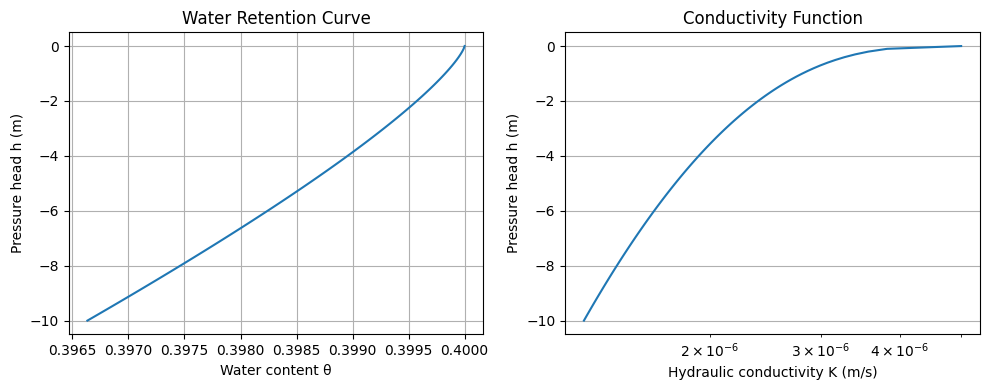

Van Genuchten functions (simple) working correctly!


In [13]:
# Block 2: Van Genuchten Soil Hydraulic Functions (simple version)
class VanGenuchten:
    def __init__(self, theta_s=0.45, theta_r=0.05, alpha=0.02, n=1.5, Ks=1e-5, l=0.5):
        self.theta_s, self.theta_r = theta_s, theta_r
        self.alpha, self.n, self.m = alpha, n, 1.0 - 1.0/n
        self.Ks, self.l = Ks, l
        self._tiny = 1e-12  # minimal guard

    def theta(self, h):
        abs_h = torch.abs(h)
        denom = (1.0 + (self.alpha * abs_h).pow(self.n)).pow(self.m)
        denom = denom + self._tiny                      # avoid 0
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.theta_s, device=h.device, dtype=h.dtype),
                           theta_unsat)

    def Se(self, h):
        th = self.theta(h)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        # keep in (0,1) to avoid fractional-power NaNs
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h):
        Se = self.Se(h)
        Se_1m = Se.pow(1.0 / self.m)
        K_unsat = self.Ks * (Se.pow(self.l)) * (1.0 - (1.0 - Se_1m).pow(self.m)).pow(2)
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.Ks, device=h.device, dtype=h.dtype),
                           torch.clamp(K_unsat, 0.0, self.Ks))  # keep nonnegative & ≤ Ks

# Test the Van Genuchten functions
if __name__ == "__main__":
    # Test with sample pressure heads
    soil = VanGenuchten(theta_s=0.4, theta_r=0.1, alpha=0.01, n=1.3, Ks=5e-6)
    h_test = torch.linspace(-10, 0, 100).unsqueeze(1)

    theta_test = soil.theta(h_test)
    K_test = soil.K(h_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(theta_test.detach().numpy(), h_test.numpy())
    ax1.set_xlabel('Water content θ')
    ax1.set_ylabel('Pressure head h (m)')
    ax1.set_title('Water Retention Curve')
    ax1.grid(True)

    ax2.semilogx(K_test.detach().numpy(), h_test.numpy())
    ax2.set_xlabel('Hydraulic conductivity K (m/s)')
    ax2.set_ylabel('Pressure head h (m)')
    ax2.set_title('Conductivity Function')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    print("Van Genuchten functions (simple) working correctly!")


In [14]:
# Block 3: Neural Network Architectures (no custom init)
class PressureHeadNet(nn.Module):
    """Neural network for pressure head h(z,t)"""
    def __init__(self, hidden_dim=32, num_layers=3):
        super().__init__()

        layers = []
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        inputs = torch.cat([z, t], dim=1)
        h = self.net(inputs)
        # Constrain pressure head to reasonable range
        return torch.clamp(h, -50.0, 5.0)

class WaterTableNet(nn.Module):
    """Neural network for water table depth z_b(t) with constraints"""
    def __init__(self, hidden_dim=20, num_layers=2):
        super().__init__()

        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, t):
        zb = self.net(t)
        # Ensure water table depth is positive and within reasonable bounds
        return torch.clamp(torch.abs(zb) + 0.5, 0.5, 5.0)

# Test the neural networks
if __name__ == "__main__":
    # Test pressure head network
    h_net = PressureHeadNet().to(device)

    # Create test inputs
    z_test = torch.linspace(-2, 0, 10).unsqueeze(1).to(device)
    t_test = torch.ones_like(z_test).to(device)

    h_output = h_net(z_test, t_test)
    print(f"Pressure head network output shape: {h_output.shape}")
    print(f"Sample pressure heads: {h_output[:5].flatten()}")

    # Test water table network
    zb_net = WaterTableNet().to(device)

    t_test = torch.linspace(0, 10, 10).unsqueeze(1).to(device)
    zb_output = zb_net(t_test)
    print(f"Water table network output shape: {zb_output.shape}")
    print(f"Sample water table depths: {zb_output[:5].flatten()}")

    print("Neural networks working correctly!")


Pressure head network output shape: torch.Size([10, 1])
Sample pressure heads: tensor([0.1096, 0.0993, 0.0878, 0.0753, 0.0620], grad_fn=<ViewBackward0>)
Water table network output shape: torch.Size([10, 1])
Sample water table depths: tensor([0.6401, 0.6207, 0.5741, 0.5538, 0.5373], grad_fn=<ViewBackward0>)
Neural networks working correctly!


In [15]:
# Block 4: Main PINN Model Class (minimal, no extra "stability" tweaks)
class RichardsPINN(nn.Module):
    """PINN for Richards equation with moving boundary"""
    def __init__(self, soil_params, q0_data, Sy=0.15):
        super().__init__()
        self.h_net = PressureHeadNet()
        self.zb_net = WaterTableNet()
        self.soil = VanGenuchten(**soil_params)
        self.Sy = torch.tensor(Sy, device=device)  # constant storage coefficient
        self.zr = 0.5  # rooting depth (kept simple)
        
        # Store surface flux data (time, flux) pairs - now required
        if q0_data is None:
            raise ValueError("q0_data is required! Provide (times, fluxes) tuple.")
        
        self.q0_times = torch.tensor(q0_data[0], dtype=torch.float32, device=device)
        self.q0_values = torch.tensor(q0_data[1], dtype=torch.float32, device=device)

    def forward(self, z, t):
        """Return h(z,t) and z_b(t)"""
        h = self.h_net(z, t)
        zb = self.zb_net(t)
        return h, zb

    def surface_flux(self, t):
        """Prescribed surface flux q0(t) - interpolated from input data"""
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)
        
        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= self.q0_times[0]:
                q0_interp[i] = self.q0_values[0]
            elif t_val >= self.q0_times[-1]:
                q0_interp[i] = self.q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(self.q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = self.q0_values[0]
                else:
                    t1, t2 = self.q0_times[idx-1], self.q0_times[idx]
                    q1, q2 = self.q0_values[idx-1], self.q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)
        
        return q0_interp.reshape_as(t)

    def root_uptake(self, z, t):
        """Simple root uptake S(z,t) in the root zone"""
        S_max = 1e-7
        return torch.where(z >= -self.zr,
                           torch.full_like(z, S_max),
                           torch.zeros_like(z))

    def compute_derivatives(self, h, z, t):
        """Raw autograd derivatives (no clipping)"""
        theta_h = self.soil.theta(h)
        dtheta_dt = torch.autograd.grad(theta_h.sum(), t, create_graph=True)[0]
        dh_dz     = torch.autograd.grad(h.sum(),       z, create_graph=True)[0]
        K_h       = self.soil.K(h)
        q         = -K_h * (dh_dz + 1.0)
        dq_dz     = torch.autograd.grad(q.sum(),       z, create_graph=True)[0]
        return dtheta_dt, dq_dz, q, K_h

    def pde_residual(self, z, t):
        """Richards equation: ∂θ/∂t = ∂q/∂z - S"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)
        h, _ = self(z, t)
        dtheta_dt, dq_dz, _, _ = self.compute_derivatives(h, z, t)
        S = self.root_uptake(z, t)
        return dtheta_dt - dq_dz + S

    def surface_bc_residual(self, t):
        """Flux BC at z=0: q(0,t) = q0(t)"""
        t = t.requires_grad_(True)
        z0 = torch.zeros_like(t, requires_grad=True, device=t.device)
        h0, _ = self(z0, t)
        K0 = self.soil.K(h0)
        dh_dz_0 = torch.autograd.grad(h0.sum(), z0, create_graph=True)[0]
        q_surf = -K0 * (dh_dz_0 + 1.0)
        q0 = self.surface_flux(t)
        return q_surf - q0

    def water_table_head_residual(self, t):
        """Head BC at WT: h(-z_b(t), t) = 0"""
        z_dummy = torch.zeros_like(t)
        _, zb = self(z_dummy, t)
        h_wt, _ = self(-zb, t)
        return h_wt

    def water_table_kinematic_residual(self, t):
        """WT kinematic: dz_b/dt = -q(-z_b,t)/S_y"""
        t = t.requires_grad_(True)
        _, zb = self(torch.zeros_like(t), t)
        dzb_dt = torch.autograd.grad(zb.sum(), t, create_graph=True)[0]
        z_wt = (-zb).requires_grad_(True)
        h_wt, _ = self(z_wt, t)
        K_wt = self.soil.K(h_wt)
        dh_dz_wt = torch.autograd.grad(h_wt.sum(), z_wt, create_graph=True)[0]
        q_wt = -K_wt * (dh_dz_wt + 1.0)
        return dzb_dt + q_wt / self.Sy

    def initial_conditions_residual(self, z, t0):
        """IC: hydrostatic guess h(z,t0)=z+z_b(t0), and z_b(t0)=1.5"""
        h, zb = self(z, t0)
        h_ic = z + zb
        zb_ic = torch.tensor(1.5, device=z.device).expand_as(zb)
        return h - h_ic, zb - zb_ic


# --- Minimal smoke test ---
if __name__ == "__main__":
    soil_params = {
        'theta_s': 0.4,
        'theta_r': 0.1,
        'alpha': 0.01,
        'n': 1.3,
        'Ks': 5e-6,
        'l': 0.5,
    }
    
    # Create simple test q0_data
    test_q0_data = ([0.0, 5.0, 10.0], [-5e-7, -5e-7, -5e-7])  # constant for testing

    model = RichardsPINN(soil_params, test_q0_data, Sy=0.15).to(device)
    print("Model created successfully!")
    print(f"# trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    z_test = torch.randn(5, 1, device=device)
    t_test = torch.randn(5, 1, device=device)

    with torch.no_grad():
        h_out, zb_out = model(z_test, t_test)
        print(f"Forward OK: h {h_out.shape}, zb {zb_out.shape}")


Model created successfully!
# trainable params: 2722
Forward OK: h torch.Size([5, 1]), zb torch.Size([5, 1])


In [16]:
# ===== Minimal Training Setup (drop-in) =====
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Device & reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(45)
np.random.seed(45)

def train_pinn(q0_data, n_epochs=1000, learning_rate=1e-3, n_collocation=300):
    """
    Minimal PINN training loop:
      - samples collocation (z,t), boundary t, and initial (z,t0) points
      - computes PDE + BC + IC residual losses
      - optimizes with Adam
      
    Args:
        q0_data: tuple of (times, fluxes) for surface flux data - REQUIRED
                 e.g., q0_data = ([0, 1, 2, 5, 10], [-1e-6, -2e-6, -1e-6, -5e-7, -3e-7])
        n_epochs: number of training epochs
        learning_rate: Adam optimizer learning rate
        n_collocation: number of collocation points for PDE
    """

    # --- Soil parameters ---
    soil_params = {
        'theta_s': 0.4,
        'theta_r': 0.1,
        'alpha'  : 0.01,
        'n'      : 1.3,
        'Ks'     : 5e-6,
        'l'      : 0.5,
    }

    # --- Model ---
    model = RichardsPINN(soil_params, q0_data, Sy=0.15).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # --- Domain ---
    z_min, z_max = -3.0, 0.0      # depth (upward-positive z)
    t_min, t_max =  0.0, 10.0     # time

    # --- Book-keeping ---
    losses = []
    comps  = {'pde': [], 'surf': [], 'wt_head': [], 'wt_kin': [], 'ic_h': [], 'ic_zb': []}

    print(f"Training for {n_epochs} epochs | collocation={n_collocation} | lr={learning_rate}")
    print(f"Domain: z∈[{z_min},{z_max}], t∈[{t_min},{t_max}]")

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ----- Sample training points -----
        # Collocation (interior): enforce PDE
        z_col = (torch.rand(n_collocation, 1)*(z_max - z_min) + z_min).to(device)
        t_col = (torch.rand(n_collocation, 1)*(t_max - t_min) + t_min).to(device)

        # Boundary (surface flux at z=0): enforce BC
        n_bc  = 100
        t_bc  = (torch.rand(n_bc, 1)*(t_max - t_min) + t_min).to(device)

        # Initial condition (t=t_min): enforce IC
        n_ic = 50
        z_ic = (torch.rand(n_ic, 1)*(z_max - z_min) + z_min).to(device)
        t_ic = (torch.zeros(n_ic, 1) + t_min).to(device)

        # ----- Compute residuals -----
        # PDE residual on interior points
        res_pde = model.pde_residual(z_col, t_col)         # shape (n_collocation, 1)
        loss_pde = (res_pde**2).mean()

        # Surface flux BC at z=0
        res_surf = model.surface_bc_residual(t_bc)         # shape (n_bc, 1)
        loss_surf = (res_surf**2).mean()

        # Water-table BCs
        res_wt_head = model.water_table_head_residual(t_bc)      # h(-zb,t)=0
        loss_wt_head = (res_wt_head**2).mean()

        res_wt_kin  = model.water_table_kinematic_residual(t_bc) # dzb/dt + q/Sy = 0
        loss_wt_kin = (res_wt_kin**2).mean()

        # Initial conditions
        res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
        loss_ic_h  = (res_ic_h**2).mean()
        loss_ic_zb = (res_ic_zb**2).mean()

        # ----- Total loss (simple equal weights to start) -----
        total_loss = (loss_pde + loss_surf + loss_wt_head +
                      loss_wt_kin + loss_ic_h + loss_ic_zb)

        # ----- Backprop + step -----
        total_loss.backward()
        optimizer.step()

        # Log
        losses.append(total_loss.item())
        comps['pde'].append(loss_pde.item())
        comps['surf'].append(loss_surf.item())
        comps['wt_head'].append(loss_wt_head.item())
        comps['wt_kin'].append(loss_wt_kin.item())
        comps['ic_h'].append(loss_ic_h.item())
        comps['ic_zb'].append(loss_ic_zb.item())

        if (epoch+1) % 200 == 0 or epoch == 0:
            print(f"[{epoch+1:4d}/{n_epochs}] "
                  f"total={total_loss.item():.3e} | "
                  f"PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}, "
                  f"WT(h)={loss_wt_head.item():.3e}, WT(kin)={loss_wt_kin.item():.3e}, "
                  f"IC(h)={loss_ic_h.item():.3e}, IC(zb)={loss_ic_zb.item():.3e}")

    print("Training done.")
    return model, losses, comps


# ===== Example run (train + plots) =====
if __name__ == "__main__":
    # Create example q0_data for training
    example_q0_data = ([0.0, 2.5, 5.0, 7.5, 10.0], [-5e-7, -1e-6, -5e-7, -8e-7, -3e-7])
    
    # Train
    model, losses, comps = train_pinn(
        example_q0_data,
        n_epochs=1000,
        learning_rate=1e-3,
        n_collocation=1000
    )

   

  


Training for 1000 epochs | collocation=1000 | lr=0.001
Domain: z∈[-3.0,0.0], t∈[0.0,10.0]
[   1/1000] total=2.846e+00 | PDE=5.390e-14, Surf=1.458e-11, WT(h)=1.301e-03, WT(kin)=7.736e-04, IC(h)=2.104e+00, IC(zb)=7.395e-01
[ 200/1000] total=5.318e-03 | PDE=1.944e-10, Surf=3.963e-11, WT(h)=4.090e-04, WT(kin)=5.118e-04, IC(h)=4.381e-03, IC(zb)=1.579e-05
[ 400/1000] total=2.967e-03 | PDE=1.948e-10, Surf=3.852e-11, WT(h)=4.746e-05, WT(kin)=3.811e-04, IC(h)=2.532e-03, IC(zb)=6.299e-06
[ 600/1000] total=1.788e-03 | PDE=1.874e-10, Surf=4.097e-11, WT(h)=4.983e-05, WT(kin)=3.423e-04, IC(h)=1.394e-03, IC(zb)=1.734e-06
[ 800/1000] total=8.591e-04 | PDE=1.853e-10, Surf=3.833e-11, WT(h)=2.253e-05, WT(kin)=6.288e-05, IC(h)=7.735e-04, IC(zb)=1.984e-07
[1000/1000] total=4.531e-04 | PDE=1.697e-10, Surf=4.307e-11, WT(h)=1.666e-05, WT(kin)=1.352e-04, IC(h)=3.013e-04, IC(zb)=1.627e-08
Training done.


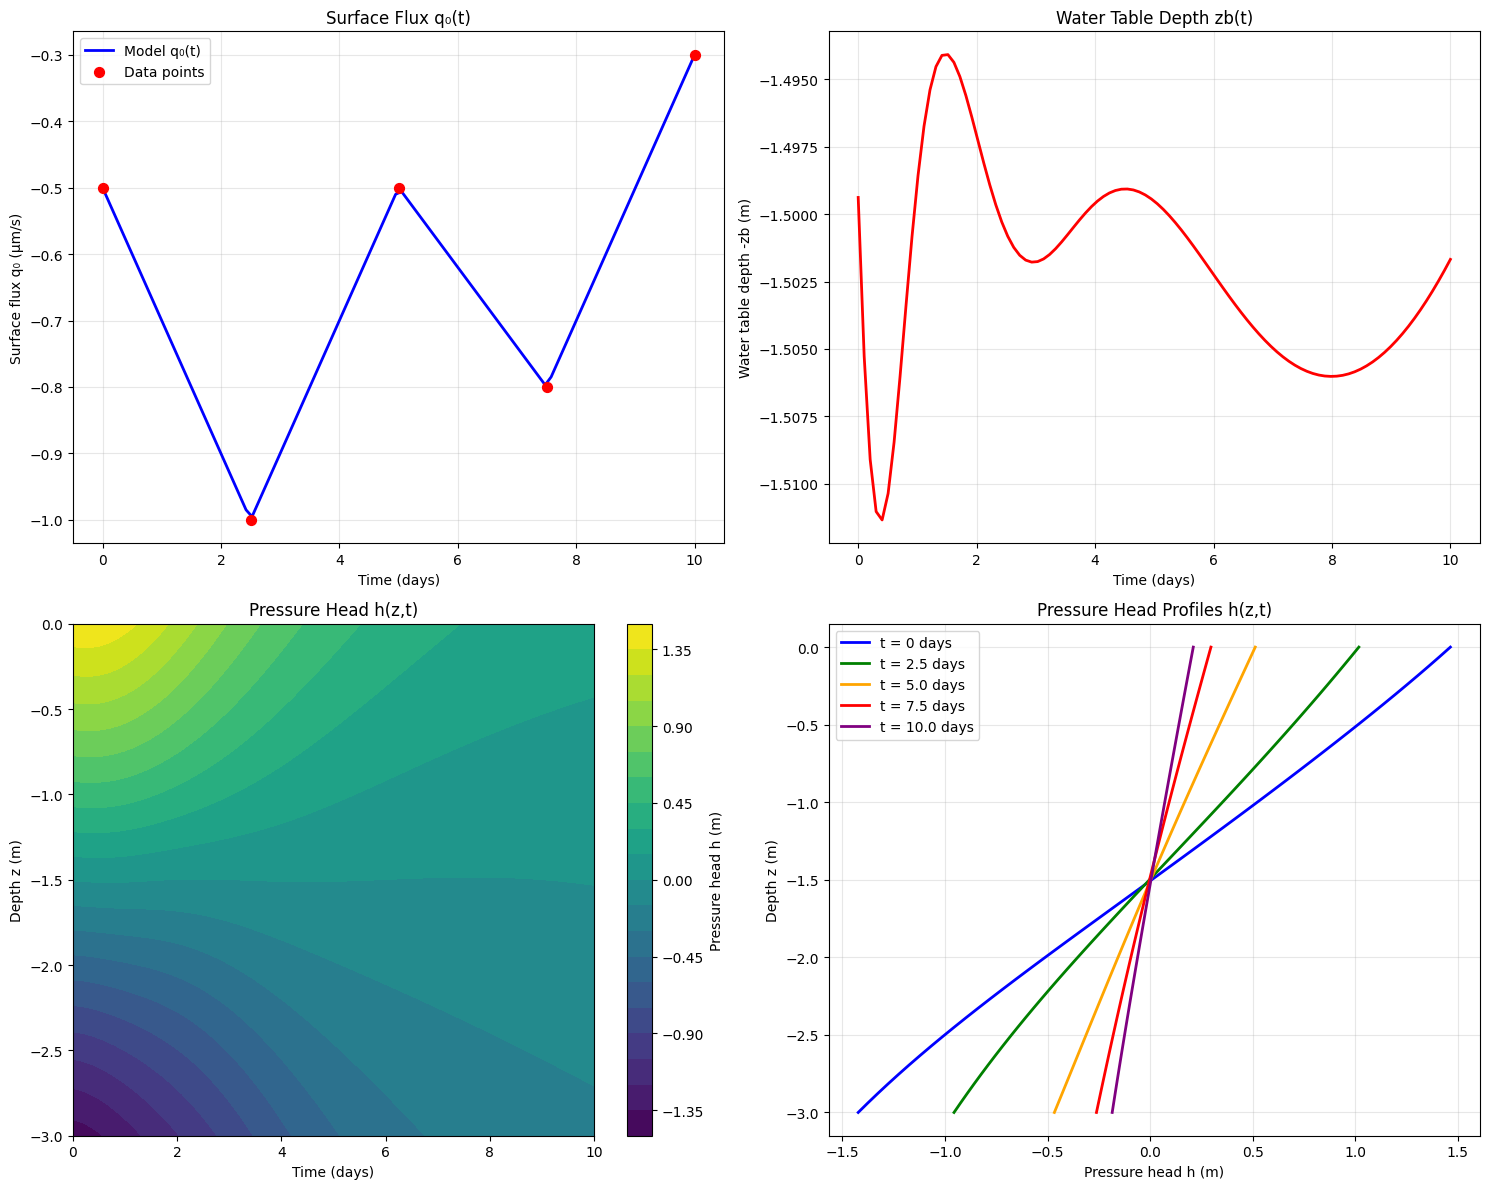


Results Summary:
Final water table depth: -1.502 m
Surface flux range: [-0.99, -0.30] μm/s
Pressure head range: [-1.423, 1.470] m


In [17]:
# Block 5: Visualization of Results
def plot_results(model, t_max=10.0, z_min=-3.0, z_max=0.0):
    """Plot q0(t), h(z,t), and zb(t) after training"""
    
    model.eval()
    
    # Create time and depth grids
    t_plot = torch.linspace(0, t_max, 100, dtype=torch.float32).unsqueeze(1).to(device)
    z_plot = torch.linspace(z_min, z_max, 50, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create meshgrid for h(z,t) surface plot
    T, Z = torch.meshgrid(t_plot.squeeze(), z_plot.squeeze(), indexing='ij')
    T_flat = T.flatten().unsqueeze(1)
    Z_flat = Z.flatten().unsqueeze(1)
    
    with torch.no_grad():
        # Surface flux q0(t)
        q0_vals = model.surface_flux(t_plot)
        
        # Water table depth zb(t)
        _, zb_vals = model(torch.zeros_like(t_plot), t_plot)
        
        # Pressure head h(z,t) on the grid
        h_vals, _ = model(Z_flat, T_flat)
        H = h_vals.reshape(T.shape)
    
    # Convert to numpy for plotting
    t_np = t_plot.cpu().numpy().squeeze()
    z_np = z_plot.cpu().numpy().squeeze()
    q0_np = q0_vals.cpu().numpy().squeeze()
    zb_np = zb_vals.cpu().numpy().squeeze()
    T_np = T.cpu().numpy()
    Z_np = Z.cpu().numpy()
    H_np = H.cpu().numpy()
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Surface flux q0(t)
    ax1.plot(t_np, q0_np * 1e6, 'b-', linewidth=2, label='Model q₀(t)')
    
    # Always plot the original data points (since q0_data is now required)
    data_times = model.q0_times.cpu().numpy()
    data_fluxes = model.q0_values.cpu().numpy()
    ax1.scatter(data_times, data_fluxes * 1e6, color='red', s=50, 
               label='Data points', zorder=5)
    ax1.legend()
    
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Surface flux q₀ (μm/s)')
    ax1.set_title('Surface Flux q₀(t)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Water table depth zb(t)
    ax2.plot(t_np, -zb_np, 'r-', linewidth=2)
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Water table depth -zb (m)')
    ax2.set_title('Water Table Depth zb(t)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Pressure head h(z,t) as contour plot
    contour = ax3.contourf(T_np, Z_np, H_np, levels=20, cmap='viridis')
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Depth z (m)')
    ax3.set_title('Pressure Head h(z,t)')
    plt.colorbar(contour, ax=ax3, label='Pressure head h (m)')
    
    # Plot 4: Pressure head profiles at different times
    times_to_plot = [0, 2.5, 5.0, 7.5, 10.0]
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    
    for i, t_val in enumerate(times_to_plot):
        t_single = torch.tensor([[t_val]], device=device, dtype=torch.float32)
        with torch.no_grad():
            h_profile, _ = model(z_plot, t_single.expand_as(z_plot))
        ax4.plot(h_profile.cpu().numpy().squeeze(), z_np, 
                color=colors[i], linewidth=2, label=f't = {t_val} days')
    
    ax4.set_xlabel('Pressure head h (m)')
    ax4.set_ylabel('Depth z (m)')
    ax4.set_title('Pressure Head Profiles h(z,t)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nResults Summary:")
    print(f"Final water table depth: {-zb_np[-1]:.3f} m")
    print(f"Surface flux range: [{q0_np.min()*1e6:.2f}, {q0_np.max()*1e6:.2f}] μm/s")
    print(f"Pressure head range: [{H_np.min():.3f}, {H_np.max():.3f}] m")

# Run the plotting function if we have a trained model
if __name__ == "__main__" and 'model' in locals():
    plot_results(model)
else:
    print("Run the training cell first to create the model, then call plot_results(model)")


In [18]:
# Block 6: Example Usage with Custom Surface Flux Data

# Example 1: Sinusoidal surface flux (e.g., seasonal variation)
def create_sinusoidal_q0_data(t_max=10.0, n_points=20):
    """Create sinusoidal surface flux data"""
    times = np.linspace(0, t_max, n_points)
    # Sinusoidal flux: varies between -1e-6 and -1e-7 m/s
    base_flux = -5e-7
    amplitude = -4e-7
    fluxes = base_flux + amplitude * np.sin(2 * np.pi * times / t_max)
    return times.tolist(), fluxes.tolist()

# Example 2: Step function (e.g., irrigation events)
def create_step_q0_data(t_max=10.0):
    """Create step function surface flux data (irrigation events)"""
    times = [0.0, 2.0, 2.5, 5.0, 5.5, 8.0, 8.5, t_max]
    fluxes = [-1e-7, -1e-7, -2e-6, -2e-6, -1e-7, -1e-7, -3e-6, -3e-6]  # irrigation pulses
    return times, fluxes

# Example 3: Exponential decay (e.g., drying after rain)
def create_exponential_q0_data(t_max=10.0, n_points=15):
    """Create exponentially decaying surface flux"""
    times = np.linspace(0, t_max, n_points)
    # Start with high flux, decay exponentially
    initial_flux = -2e-6
    decay_rate = 0.3
    fluxes = initial_flux * np.exp(-decay_rate * times)
    return times.tolist(), fluxes.tolist()

# Example usage functions
def train_with_custom_flux(flux_type='sinusoidal', n_epochs=1000):
    """Train PINN with different flux types"""
    
    print(f"Training with {flux_type} surface flux...")
    
    if flux_type == 'sinusoidal':
        q0_data = create_sinusoidal_q0_data()
    elif flux_type == 'step':
        q0_data = create_step_q0_data()
    elif flux_type == 'exponential':
        q0_data = create_exponential_q0_data()
    else:
        raise ValueError(f"Unknown flux type: {flux_type}. Use 'sinusoidal', 'step', or 'exponential'")
    
    # Train the model
    model, losses, comps = train_pinn(
        q0_data,
        n_epochs=n_epochs,
        learning_rate=1e-3,
        n_collocation=1000
    )
    
    # Plot results
    plot_results(model)
    
    return model, losses, comps

# Example: Train with your own data
def train_with_your_data(times, fluxes, n_epochs=1000):
    """
    Train PINN with your custom surface flux data
    
    Args:
        times: list or array of time points (days)
        fluxes: list or array of surface flux values (m/s, negative = downward)
        n_epochs: number of training epochs
    
    Example:
        # Your measurement data
        my_times = [0, 1, 3, 5, 7, 10]  # days
        my_fluxes = [-1e-6, -2e-6, -1e-6, -5e-7, -8e-7, -3e-7]  # m/s
        
        model, losses, comps = train_with_your_data(my_times, my_fluxes, n_epochs=1500)
    """
    q0_data = (times, fluxes)
    
    print(f"Training with custom data: {len(times)} time points")
    print(f"Time range: {min(times):.1f} to {max(times):.1f} days")
    print(f"Flux range: {min(fluxes)*1e6:.1f} to {max(fluxes)*1e6:.1f} μm/s")
    
    model, losses, comps = train_pinn(
        q0_data,
        n_epochs=n_epochs,
        learning_rate=1e-3,
        n_collocation=1000
    )
    
    plot_results(model)
    return model, losses, comps

print("Surface flux data-driven PINN ready!")
print("Available functions:")
print("  - train_with_custom_flux('sinusoidal')")
print("  - train_with_custom_flux('step')")  
print("  - train_with_custom_flux('exponential')")
print("  - train_with_your_data(times, fluxes)")
print("  - Or use train_pinn(q0_data=(times, fluxes)) directly")
print("\nNote: q0_data is now REQUIRED - no default constant flux!")


Surface flux data-driven PINN ready!
Available functions:
  - train_with_custom_flux('sinusoidal')
  - train_with_custom_flux('step')
  - train_with_custom_flux('exponential')
  - train_with_your_data(times, fluxes)
  - Or use train_pinn(q0_data=(times, fluxes)) directly

Note: q0_data is now REQUIRED - no default constant flux!


Training PINN with sinusoidal surface flux...
This represents seasonal variation in surface flux
Training with sinusoidal surface flux...
Training for 1500 epochs | collocation=1000 | lr=0.001
Domain: z∈[-3.0,0.0], t∈[0.0,10.0]
[   1/1500] total=2.141e+00 | PDE=6.390e-12, Surf=8.417e-12, WT(h)=5.088e-02, WT(kin)=9.273e-03, IC(h)=1.210e+00, IC(zb)=8.715e-01
[ 200/1500] total=6.072e-03 | PDE=2.014e-10, Surf=3.128e-11, WT(h)=6.229e-04, WT(kin)=1.965e-03, IC(h)=3.484e-03, IC(zb)=1.283e-08
[ 400/1500] total=3.311e-03 | PDE=2.592e-10, Surf=3.044e-11, WT(h)=6.792e-05, WT(kin)=2.389e-04, IC(h)=3.004e-03, IC(zb)=4.017e-07
[ 600/1500] total=1.756e-03 | PDE=2.496e-10, Surf=3.229e-11, WT(h)=4.619e-05, WT(kin)=9.508e-05, IC(h)=1.612e-03, IC(zb)=2.150e-06
[ 800/1500] total=6.923e-04 | PDE=2.164e-10, Surf=3.456e-11, WT(h)=6.275e-06, WT(kin)=3.179e-05, IC(h)=6.538e-04, IC(zb)=4.202e-07
[1000/1500] total=3.824e-04 | PDE=2.822e-10, Surf=3.431e-11, WT(h)=1.022e-05, WT(kin)=2.423e-05, IC(h)=3.478e-04, IC(

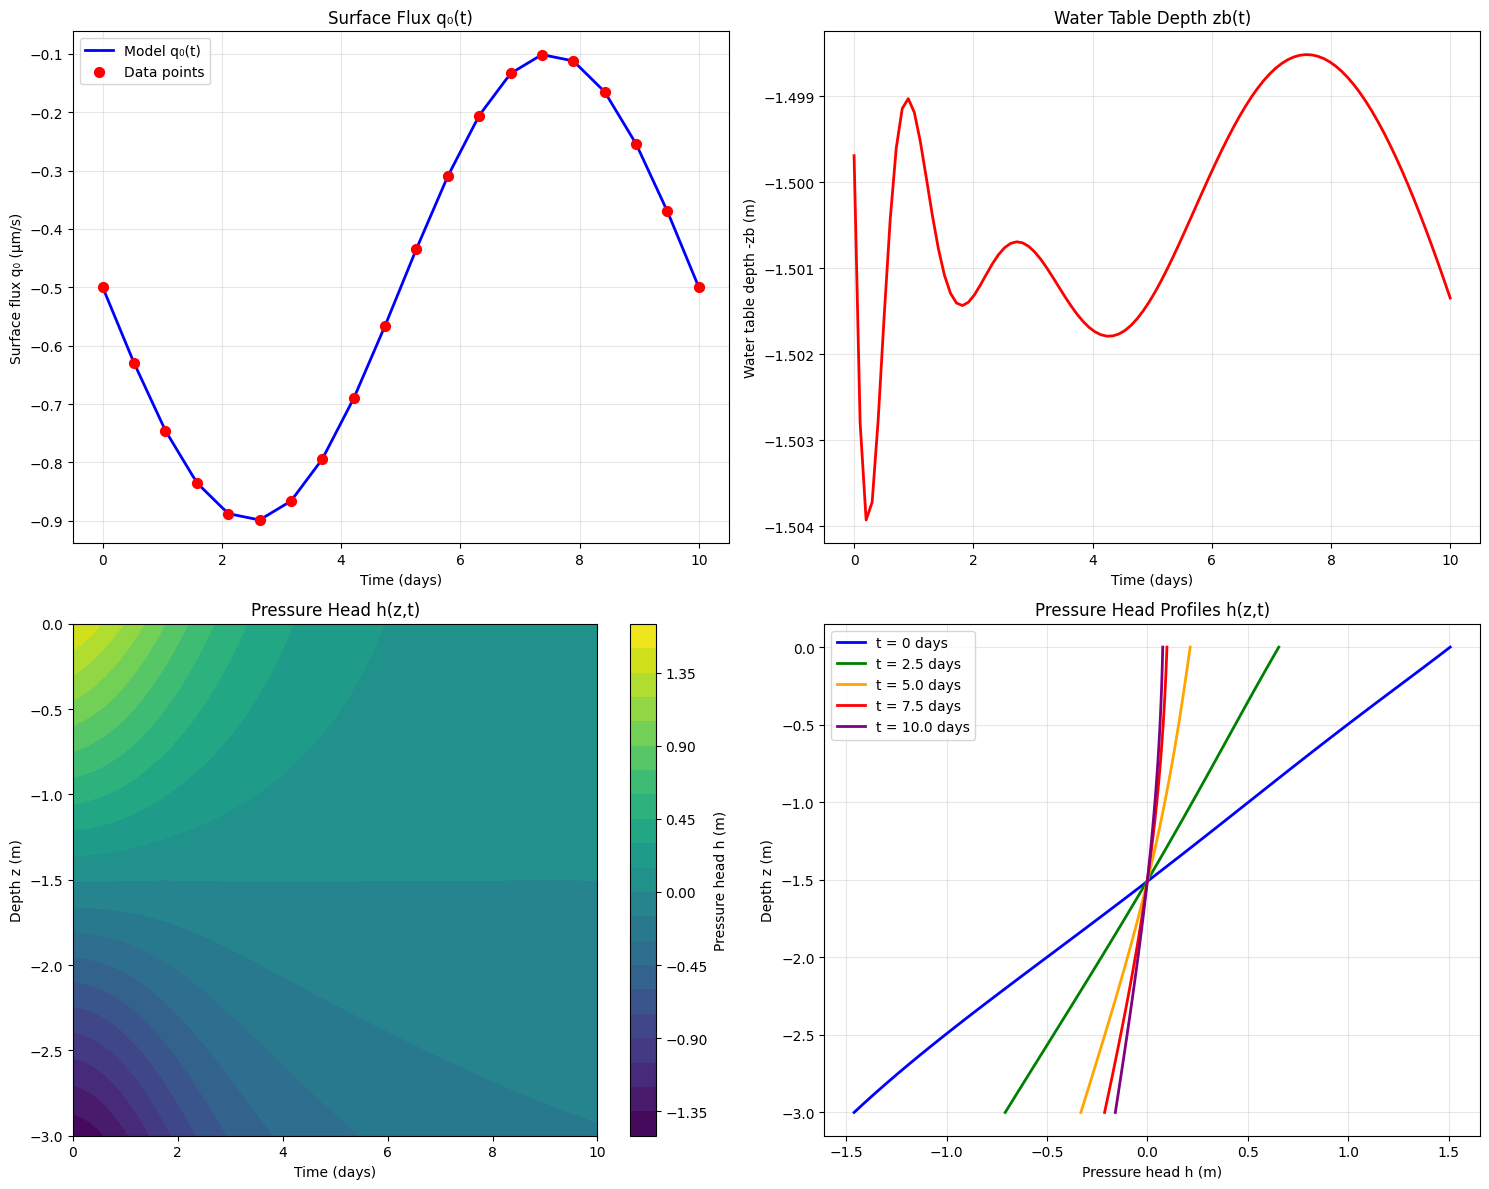


Results Summary:
Final water table depth: -1.501 m
Surface flux range: [-0.90, -0.10] μm/s
Pressure head range: [-1.460, 1.508] m

Training completed! The plots above show:
- Surface flux q₀(t): sinusoidal pattern with data points
- Water table depth: how it responds to varying flux
- Pressure head: spatio-temporal evolution
- Pressure profiles: evolution over time


In [19]:
# Block 7: Train with Sinusoidal Surface Flux

# Train the model with sinusoidal surface flux
print("Training PINN with sinusoidal surface flux...")
print("This represents seasonal variation in surface flux")

# Train with sinusoidal flux pattern
model_sin, losses_sin, comps_sin = train_with_custom_flux('sinusoidal', n_epochs=1500)

print("\nTraining completed! The plots above show:")
print("- Surface flux q₀(t): sinusoidal pattern with data points")
print("- Water table depth: how it responds to varying flux")
print("- Pressure head: spatio-temporal evolution")
print("- Pressure profiles: evolution over time")
